In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [2]:
def generate_data(rng_key, D, num):
    rng_key, _ = jax.random.split(rng_key)
    X = jax.random.uniform(rng_key, shape=(num, D - 1), minval=-1.0, maxval=1.0)
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    rng_key, _ = jax.random.split(rng_key)
    theta_true = jax.random.normal(rng_key, shape=(D, 1))
    rng_key, _ = jax.random.split(rng_key)
    Y = X_with_one @ theta_true + jax.random.normal(rng_key, shape=(num, 1)) * 0.1
    return X, Y


In [25]:
X.shape

(5, 99)

In [34]:
seed = 0
N = 10
D = 10
rng_key = jax.random.PRNGKey(seed)
X, Y = generate_data(rng_key, D, N)

In [35]:

X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
alpha = 1.0
noise = 1.0
beta_inv = noise ** 2
beta = 1.0 / beta_inv

# S0 = jnp.eye(D) * (alpha ** 2)
# S0_inv = jnp.eye(D) / (alpha ** 2)

S0 = jnp.array([3.9073747 , 3.35371095, 2.01823147, 1.39685824, 2.56994901,
       1.86908384, 2.94534884, 0.98075753, 1.31105521, 1.72276084])
S0_inv = 1. / S0
post_var = jnp.linalg.inv(S0_inv + beta * X_with_one.T @ X_with_one)
post_mean = beta * post_var @ X_with_one.T @ Y

In [36]:
post_var.shape

(10, 10)

In [37]:
post_var

Array([[ 1.26215756e+00,  1.30422723e+00,  3.04152459e-01,
         1.22516501e+00, -1.06938159e+00, -3.63065213e-01,
        -5.54028511e-01, -1.03014398e+00,  2.12765068e-01,
        -1.05024672e+00],
       [ 1.34952247e+00,  1.48744974e+01, -1.50931418e-01,
         1.84455032e+01, -3.20692024e+01,  1.02471495e+01,
         3.87143040e+00, -1.37015505e+01,  5.36401844e+00,
        -7.32366037e+00],
       [ 3.87818754e-01,  1.09541111e-01,  1.46934283e+00,
        -4.83824700e-01,  1.72960436e+00, -1.72228467e+00,
        -4.13324535e-01,  1.58927992e-01, -2.56601304e-01,
        -6.93598926e-01],
       [ 1.45977128e+00,  1.90809307e+01, -6.59168482e-01,
         2.46175919e+01, -4.28255806e+01,  1.41356201e+01,
         5.50361252e+00, -1.79536419e+01,  7.29637766e+00,
        -9.34837437e+00],
       [-1.48672092e+00, -3.32489204e+01,  1.95037591e+00,
        -4.30811615e+01,  7.77629929e+01, -2.73443146e+01,
        -1.07483425e+01,  3.12688808e+01, -1.28012409e+01,
         1.

In [20]:
jnp.linalg.inv(post_var)

Array([[ 179.46677  ,  -40.934242 , -105.25525  , ...,  102.44061  ,
        -115.86914  ,  -37.505043 ],
       [ -40.931442 ,   96.346085 ,    9.560503 , ...,  -80.03364  ,
          58.144325 ,   46.05656  ],
       [-105.24153  ,    9.551741 ,  207.90834  , ...,   -7.9082127,
          46.529602 ,   54.2076   ],
       ...,
       [ 102.44922  ,  -80.040215 ,   -7.9333763, ...,  188.06876  ,
        -148.24524  , -225.19109  ],
       [-115.876495 ,   58.149853 ,   46.548485 , ..., -148.24515  ,
         155.4599   ,  173.8306   ],
       [ -37.515766 ,   46.060238 ,   54.239174 , ..., -225.18677  ,
         173.82985  ,  501.0203   ]], dtype=float32)

In [197]:
import numpy as np

def log_posterior(theta, X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param theta: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: std for Gaussian likelihood
    :return:
    """
    D = prior_cov.shape[0]
    N = Y.shape[0]
    prior_cov = jnp.diag(prior_cov.squeeze())
    log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    log_llk = jax.scipy.stats.multivariate_normal.logpdf((X_with_one @ theta - Y).squeeze(),
                                                         mean=jnp.zeros([N]),
                                                         cov=noise ** 2).sum()
    return log_prior + log_llk

def posterior_full(X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: float
    :return:
    """
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    prior_cov = jnp.diag(prior_cov.squeeze())
    prior_cov_inv = jnp.diag(1. / prior_cov.squeeze())
    beta_inv = noise ** 2
    beta = 1. / beta_inv
    post_cov = jnp.linalg.inv(prior_cov_inv + beta * X_with_one.T @ X_with_one)
    post_mean = beta * post_cov @ X_with_one.T @ Y
    return post_mean, post_cov


def generate_data(rng_key, D, N, noise):
    """
    :param rng_key:
    :param D: int
    :param N: int
    :param noise: std for Gaussian likelihood
    :return: X is N*(D-1), Y is N*1
    """
    rng_key, _ = jax.random.split(rng_key)
    X = jax.random.uniform(rng_key, shape=(N, D - 1), minval=-1.0, maxval=1.0)
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    rng_key, _ = jax.random.split(rng_key)
    theta_true = jax.random.normal(rng_key, shape=(D, 1))
    rng_key, _ = jax.random.split(rng_key)
    Y = X_with_one @ theta_true + jax.random.normal(rng_key, shape=(N, 1)) * noise
    return X, Y


log_posterior_vmap = jax.vmap(log_posterior, in_axes=(0, None, None, None, None), out_axes=0)

from tensorflow_probability.substrates import jax as tfp

def MCMC(rng_key, nsamples, init_params, log_prob, post_mean, post_var):
    rng_key, _ = jax.random.split(rng_key)

    @jax.jit
    def run_chain(rng_key, state):
        num_burnin_steps = int(5e3)
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_prob,
                                           num_leapfrog_steps=30,
                                           step_size=1e-2),
                                           num_adaptation_steps=int(num_burnin_steps * 0.8))

        # kernel = tfp.mcmc.NoUTurnSampler(log_prob, 1e-3)
        # kernel = tfp.mcmc.RandomWalkMetropolis(log_prob)
        return tfp.mcmc.sample_chain(num_results=nsamples,
                                     num_burnin_steps=num_burnin_steps,
                                     current_state=state,
                                     kernel=kernel,
                                     trace_fn=None,
                                     seed=rng_key)

    states = run_chain(rng_key, init_params)
    # Debug code
    fig = plt.figure(figsize=(15, 6))
    ax_0, ax_1 = fig.subplots(1, 2)
    prior_std = jnp.sqrt(jnp.diag(post_var))

    x = jnp.linspace(post_mean[0] - 3 * prior_std[0], post_mean[0] + 3 * prior_std[0], 100)
    beta_0_post = states[:, 0, :]
    ax_0.plot(x, jax.scipy.stats.norm.pdf(x, post_mean[0], prior_std[0]), color='black', linewidth=5)
    ax_0.hist(np.array(beta_0_post), bins=10, alpha=0.8, density=True)

    x = jnp.linspace(post_mean[1] - 3 * prior_std[1], post_mean[1] + 3 * prior_std[1], 100)
    beta_1_post = states[:, 1, :]
    ax_1.plot(x, jax.scipy.stats.norm.pdf(x, post_mean[1], prior_std[1]), color='black', linewidth=5)
    ax_1.hist(np.array(beta_1_post), bins=10, alpha=0.8, density=True)

    plt.show()
    # pause = True
    return states


In [198]:
from functools import partial

seed = 1
rng_key = jax.random.PRNGKey(seed)
D = 2
N = 5
prior_covariance = 5.0
noise = 0.1
X, Y = generate_data(rng_key, D, N, noise)

# This is the test point
alpha_test = jax.random.uniform(rng_key, shape=(D, 1), minval=-1.0, maxval=1.0)
cov_test = jnp.array([[prior_covariance] * D]).T + alpha_test
log_prob = partial(log_posterior, X=X, Y=Y, prior_cov=cov_test, noise=noise)
grad_log_prob = jax.grad(log_prob, argnums=0)
grad_log_prob_vmap = jax.vmap(grad_log_prob, in_axes=(0, ), out_axes=0)

post_mean, post_var = posterior_full(X, Y, cov_test, noise)
g_test_true = post_mean.sum()

init_params = jnp.array([[0.] * D]).T

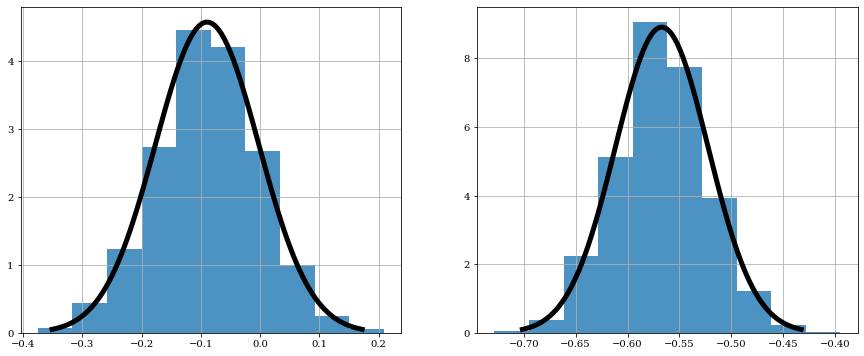

In [199]:
init_params = jnp.array([[0.1] * D]).T
states_test = MCMC(rng_key, N_MCMC, init_params, log_prob, post_mean, post_var)
states_test = jnp.unique(states_test, axis=0)
rng_key, _ = jax.random.split(rng_key)
states_test = jax.random.permutation(rng_key, states_test)

In [147]:
def log_true_posterior(theta, mean, cov):
    return jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                      mean=mean,
                                                      cov=cov).sum()

log_true_posterior = partial(log_true_posterior, mean=post_mean, cov=post_var)
log_true_posterior_vmap = jax.vmap(log_true_posterior, in_axes=(0, ), out_axes=0)

grad_log_true_posterior = jax.grad(log_true_posterior)
grad_log_true_posterior_vmap = jax.vmap(grad_log_true_posterior, in_axes=(0, ), out_axes=0)

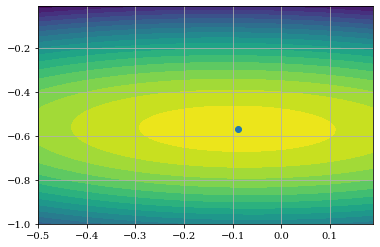

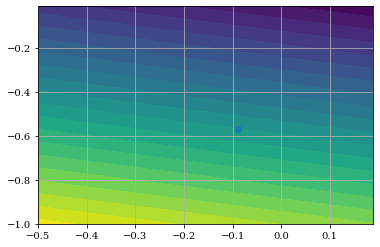

In [129]:
x, y = jnp.mgrid[-0.5:0.2:.01, -1:0:.01]
pos = jnp.dstack((x, y)).reshape([-1, 2])
V = log_posterior_vmap(pos, X, Y, cov_test, noise)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, V.reshape([70, 100]), levels=20)
ax2.scatter(post_mean[0], post_mean[1])



x, y = jnp.mgrid[-0.5:0.2:.01, -1:0:.01]
pos = jnp.dstack((x, y)).reshape([-1, 2])
grad_V = grad_log_prob_vmap(pos).sum(-1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, grad_V.reshape([70, 100]), levels=20)
ax2.scatter(post_mean[0], post_mean[1])

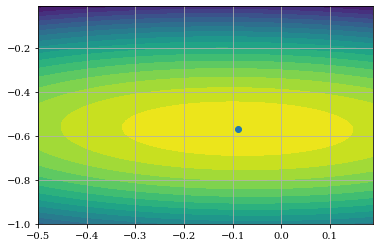

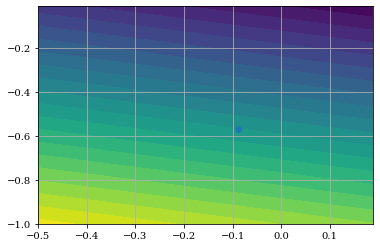

In [149]:
x, y = jnp.mgrid[-0.5:0.2:.01, -1:0:.01]
pos = jnp.dstack((x, y)).reshape([-1, 2])
V = log_true_posterior_vmap(pos)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, V.reshape([70, 100]), levels=20)
ax2.scatter(post_mean[0], post_mean[1])


x, y = jnp.mgrid[-0.5:0.2:.01, -1:0:.01]
pos = jnp.dstack((x, y)).reshape([-1, 2])
grad_V = grad_log_true_posterior_vmap(pos).sum(-1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, grad_V.reshape([70, 100]), levels=20)
ax2.scatter(post_mean[0], post_mean[1])

In [169]:
print(grad_log_true_posterior(pos[0, :]))

print(grad_log_prob(pos[0, :]))

[ 59.167038 221.34514 ]
[ 58.991753 221.25073 ]


In [167]:
pos.shape

(7000, 2)

In [161]:
grad_log_prob(post_mean)

Array([-0.09493171, -0.01821168], dtype=float32)

In [160]:
grad_log_true_posterior(post_mean)

Array([0., 0.], dtype=float32)

In [52]:
post_mean.shape

(2,)

In [130]:
def log_posterior_1(theta, X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param theta: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: std for Gaussian likelihood
    :return:
    """
    D = prior_cov.shape[0]
    N = Y.shape[0]
    prior_cov = jnp.diag(prior_cov.squeeze())
    log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()
    return log_prior + log_llk


def log_posterior_2(theta, X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param theta: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: std for Gaussian likelihood
    :return:
    """
    D = prior_cov.shape[0]
    N = Y.shape[0]
    prior_cov = jnp.diag(prior_cov.squeeze())
    log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta,
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()
    return log_prior + log_llk

In [131]:
log_prob_1 = partial(log_posterior_1, X=X, Y=Y, prior_cov=cov_test, noise=noise)
grad_log_prob_1 = jax.grad(log_prob_1, argnums=0)

log_prob_2 = partial(log_posterior_2, X=X, Y=Y, prior_cov=cov_test, noise=noise)
grad_log_prob_2 = jax.grad(log_prob_2, argnums=0)

In [132]:
init_params

Array([[0.1],
       [0.1]], dtype=float32)

In [133]:
grad_log_prob_1(init_params)

Array([[-0.0203769 ],
       [-0.01674181]], dtype=float32)

In [ ]:
log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()

In [154]:
f = partial(jax.scipy.stats.multivariate_normal.logpdf, mean=0., cov=1.)
f_vmap = jax.vmap(f, in_axes=(0, ), out_axes=0)


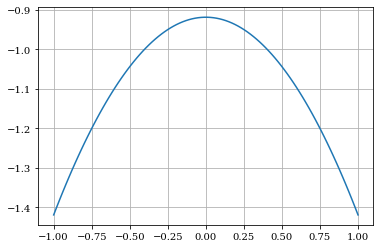

In [155]:
plt.figure()
a = jnp.linspace(-1, 1, 100)
plt.plot(a, f(a))
plt.show()

In [156]:
jnp.log(1. / jnp.sqrt(2 * jnp.pi) * jnp.exp(0))

Array(-0.9189385, dtype=float32, weak_type=True)

In [157]:
grad_f = jax.grad(f)

grad_f_vmap = jax.vmap(grad_f, in_axes=(0, ), out_axes=0)


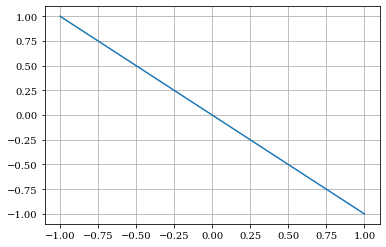

In [159]:
plt.figure()
a = jnp.linspace(-1, 1, 100)
plt.plot(a, grad_f_vmap(a))
plt.show()

In [176]:
def log_posterior(theta, X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param theta: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: std for Gaussian likelihood
    :return:
    """
    D = prior_cov.shape[0]
    N = Y.shape[0]
    prior_cov = jnp.diag(prior_cov.squeeze())
    log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    log_llk = jax.scipy.stats.multivariate_normal.logpdf((X_with_one @ theta - Y).squeeze(),
                                                         mean=jnp.zeros([N]),
                                                         cov=noise ** 2).sum()
    return log_prior


log_prob = partial(log_posterior, X=X, Y=Y, prior_cov=cov_test, noise=noise)
grad_log_posterior = jax.grad(log_prob)

In [171]:
theta = jnp.array([[0.1] * D]).T

In [178]:
theta.shape

(2, 1)

In [173]:
cov_test

Array([[4.9075174],
       [5.973068 ]], dtype=float32)

In [179]:
-jnp.diag(1. / cov_test.squeeze()) @ theta

Array([[-0.0203769 ],
       [-0.01674181]], dtype=float32)

In [177]:
grad_log_posterior(theta)

Array([[-0.0203769 ],
       [-0.01674181]], dtype=float32)

In [180]:
def log_posterior(theta, X, Y, prior_cov, noise):
    """
    :param prior_cov: D*1 array
    :param theta: D*1 array
    :param X: N*(D-1) array
    :param Y: N*1 array
    :param noise: std for Gaussian likelihood
    :return:
    """
    D = prior_cov.shape[0]
    N = Y.shape[0]
    prior_cov = jnp.diag(prior_cov.squeeze())
    log_prior = jax.scipy.stats.multivariate_normal.logpdf(theta.squeeze(),
                                                           mean=jnp.zeros([D]),
                                                           cov=prior_cov).sum()
    X_with_one = jnp.hstack([X, jnp.ones([X.shape[0], 1])])
    log_llk = jax.scipy.stats.multivariate_normal.logpdf((X_with_one @ theta - Y).squeeze(),
                                                         mean=jnp.zeros([N]),
                                                         cov=noise ** 2).sum()
    return log_llk


log_prob = partial(log_posterior, X=X, Y=Y, prior_cov=cov_test, noise=noise)
grad_log_posterior = jax.grad(log_prob)

In [182]:
- (Y - X_with_one @ theta).T @ X / (noise ** 2)

Array([[22.32974 ],
       [19.979633],
       [20.570786],
       [20.407553],
       [20.963993]], dtype=float32)

In [186]:
(Y - X_with_one @ theta).shape

(5, 5)

In [185]:
Y - 

(5,)